## Customer churn with Logistic Regression

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt

## Load the dataset

In [2]:
!wget -O ChurnData.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/ChurnData.csv

--2020-08-15 14:44:35--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/ChurnData.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36144 (35K) [text/csv]
Saving to: ‘ChurnData.csv’

100%[======================================>] 36,144      --.-K/s   in 0.07s   

2020-08-15 14:44:36 (474 KB/s) - ‘ChurnData.csv’ saved [36144/36144]



In [104]:
churn_df = pd.read_csv("ChurnData.csv")

In [105]:
churn_df.head()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,longmon,...,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,4.40,...,1.0,0.0,1.0,1.0,0.0,1.482,3.033,4.913,4.0,1.0
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,9.45,...,0.0,0.0,0.0,0.0,0.0,2.246,3.240,3.497,1.0,1.0
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,6.30,...,0.0,0.0,0.0,1.0,0.0,1.841,3.240,3.401,3.0,0.0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,6.05,...,1.0,1.0,1.0,1.0,1.0,1.800,3.807,4.331,4.0,0.0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,7.10,...,0.0,0.0,1.0,1.0,0.0,1.960,3.091,4.382,3.0,0.0


In [106]:
churn_df.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 28 columns):
tenure      200 non-null float64
age         200 non-null float64
address     200 non-null float64
income      200 non-null float64
ed          200 non-null float64
employ      200 non-null float64
equip       200 non-null float64
callcard    200 non-null float64
wireless    200 non-null float64
longmon     200 non-null float64
tollmon     200 non-null float64
equipmon    200 non-null float64
cardmon     200 non-null float64
wiremon     200 non-null float64
longten     200 non-null float64
tollten     200 non-null float64
cardten     200 non-null float64
voice       200 non-null float64
pager       200 non-null float64
internet    200 non-null float64
callwait    200 non-null float64
confer      200 non-null float64
ebill       200 non-null float64
loglong     200 non-null float64
logtoll     200 non-null float64
lninc       200 non-null float64
custcat     200 non-null float64
chur

In [107]:
churn_df.shape

(200, 28)

In [108]:
churn_df.isnull ().sum ().sum ()

0

## Data pre-processing and selection

In [109]:
churn_df_corr = churn_df.corr ()

In [110]:
import seaborn as sns

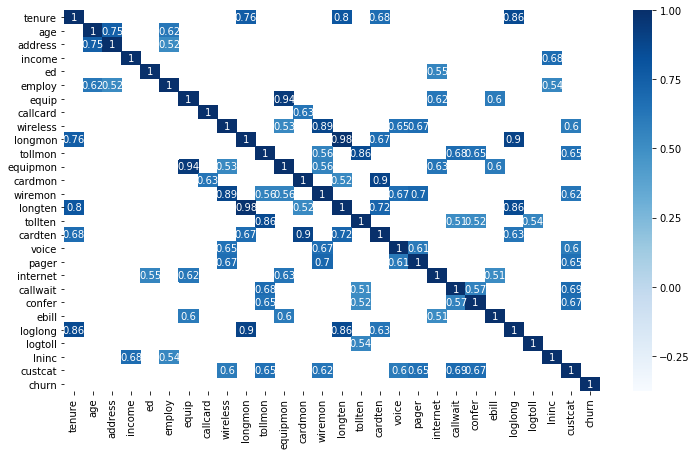

In [111]:
plt.figure (figsize = (12,7))
sns.heatmap (churn_df_corr, mask = churn_df_corr < 0.5, annot = True, cmap = 'Blues')
plt.show ()

In [112]:
corr_matrix = churn_df_corr.values
from itertools import product
L = []
for i,j in product (range (0,28),range (0,28)):
    if (corr_matrix [i,j] > 0.6) & (corr_matrix [i,j] < 1):
        L.append (i)
print (L)

[0, 0, 0, 0, 1, 1, 2, 3, 5, 6, 6, 6, 7, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 23, 23, 25, 26, 26, 26, 26, 26, 26]


In [113]:
most_corr = pd.Series (L)
M = list (most_corr.value_counts ().index [0:7])
L = list (churn_df_corr.iloc [M,:].index)
print (L)

['custcat', 'cardten', 'pager', 'longmon', 'tollmon', 'longten', 'voice']


In [36]:
churn_df['churn'] = churn_df['churn'].astype('int')

In [647]:
y = churn_df ['churn'].values
X = churn_df [['income','cardmon','age','callcard','equip',
       'tenure']]

In [648]:
features = list (X.columns)

In [649]:
X = X.values

In [650]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit_transform(X)

## Train/Test Split

In [651]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (160, 6) (160,)
Test set: (40, 6) (40,)


## Modelling with logistic regression

In [652]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [689]:
LR = LogisticRegression (C = 0.001, solver = 'liblinear')

In [690]:
LR.fit (X_train, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [691]:
y_hat = LR.predict (X_test)

In [692]:
y_hat

array([0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0.])

In [693]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob [0:2]

array([[0.50851889, 0.49148111],
       [0.52441665, 0.47558335]])

## Evaluation

In [694]:
# log_loss
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.6775999400111569

In [695]:
# jaccard index
from sklearn.metrics import jaccard_similarity_score, accuracy_score
print (jaccard_similarity_score(y_test, y_hat))
print (accuracy_score (y_test, y_hat))

0.8
0.8


In [696]:
# confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import itertools
print (confusion_matrix (y_test, y_hat))
print ('\n')
print (classification_report (y_test, y_hat))

[[23  2]
 [ 6  9]]


              precision    recall  f1-score   support

         0.0       0.79      0.92      0.85        25
         1.0       0.82      0.60      0.69        15

   micro avg       0.80      0.80      0.80        40
   macro avg       0.81      0.76      0.77        40
weighted avg       0.80      0.80      0.79        40



Text(0.5, 1.0, 'Confusion matrix')

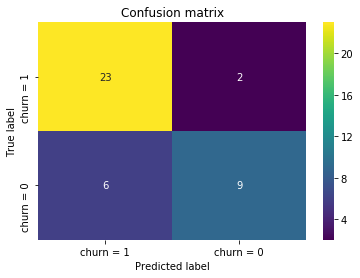

In [680]:
sns.heatmap (confusion_matrix (y_test, y_hat), yticklabels = ['churn = 1', 'churn = 0'], xticklabels = ['churn = 1', 'churn = 0'], cmap = 'viridis', annot = True)
plt.xlabel ('Predicted label')
plt.ylabel ('True label')
plt.title ('Confusion matrix')

In [662]:
imp = pd.DataFrame (abs (LR.coef_), columns = features, index = ['weights']).transpose ()

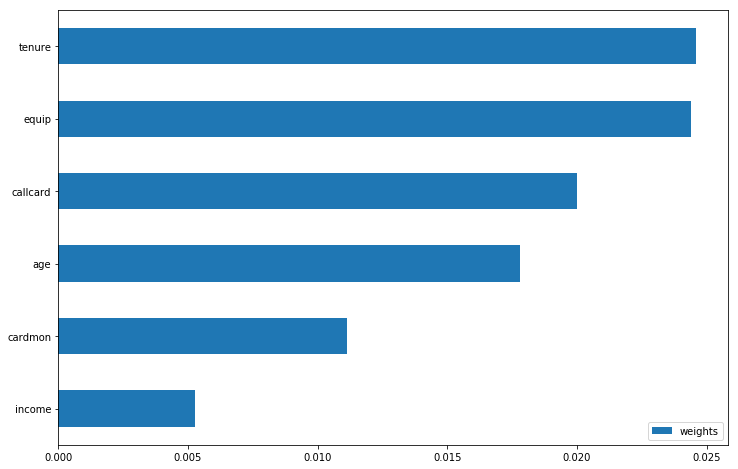

In [663]:
imp = imp.sort_values (by = ['weights'])
imp.plot.barh (figsize = (12,8))

In [664]:
imp.index

Index(['income', 'cardmon', 'age', 'callcard', 'equip', 'tenure'], dtype='object')